## Proyecto Beta Bank Aprendizaje Supervisado

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

### EDA

##### Carga de librerias y datos 

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (
        KFold,
    StratifiedKFold,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.datasets import (
    make_classification,
    make_regression
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

In [101]:
df_bank = pd.read_csv('Churn.csv')

##### Descripción básica (shape, tipos de datos)

In [102]:
print('El dataframe tiene la siguiente dimensión de datos (filas, columnas):', df_bank.shape)
print('\nTiene los siguientes tipos de datos:')
print(df_bank.dtypes)
print('\nInformación del dataframe:')
df_bank.info()
print('\nUna pequeña muestra de 5 registros dentro del dataframe:')
print(df_bank.sample(5))  # sample para mostrar 5 filas aleatorias

El dataframe tiene la siguiente dimensión de datos (filas, columnas): (10000, 14)

Tiene los siguientes tipos de datos:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Información del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 no

##### Conteo de valores nulos/faltantes y estadistica descriptiva

In [103]:
print(df_bank.isnull().sum())

print(df_bank.describe())

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64
         RowNumber    CustomerId   CreditScore           Age       Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  9091.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800     4.997690   
std     2886.89568  7.193619e+04     96.653299     10.487806     2.894723   
min        1.00000  1.556570e+07    350.000000     18.000000     0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000     2.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000     5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000     7.000000   
max    10000.00000  1.581569e+07    850.000000   

Al tener valores nulos en el campo "Ternure", voy a asumir que es por que el cliente nunca a tenido un deposito a plazo fijo. Por lo que lo imputare con el valor "0".

In [104]:
df_bank['Tenure']=df_bank['Tenure'].fillna(0)
print(df_bank.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64



##### Gráficas simples (distribución, dispersión, correlaciones)


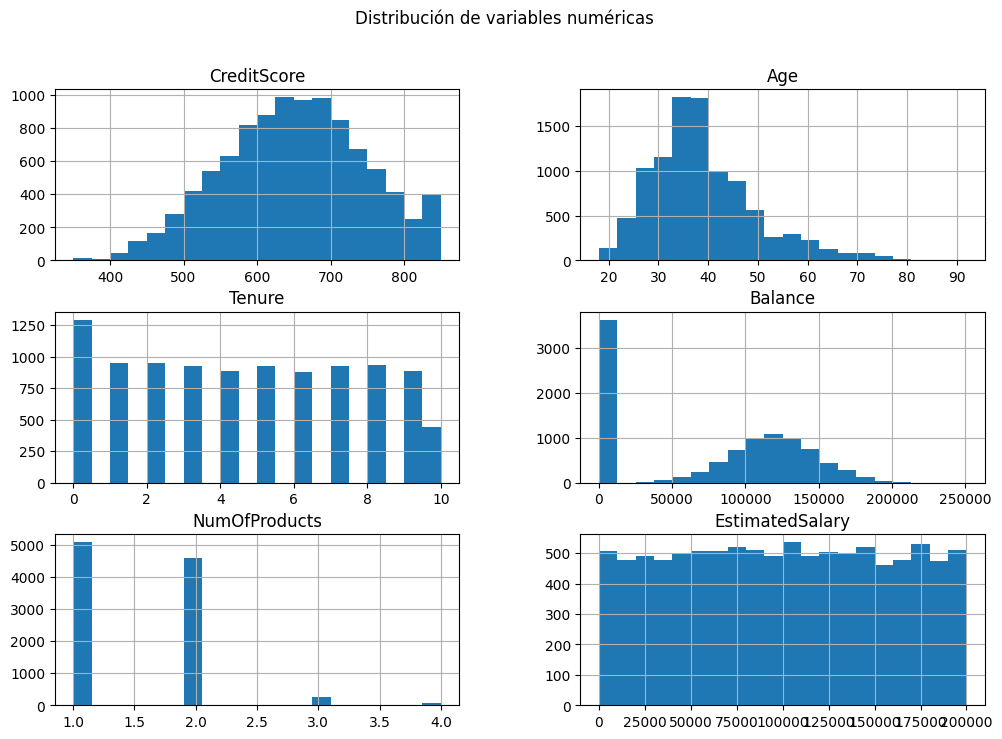

In [105]:
import matplotlib.pyplot as plt

# Lista de variables numéricas
numericas = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

df_bank[numericas].hist(bins=20, figsize=(12,8))
plt.suptitle('Distribución de variables numéricas')
plt.show()


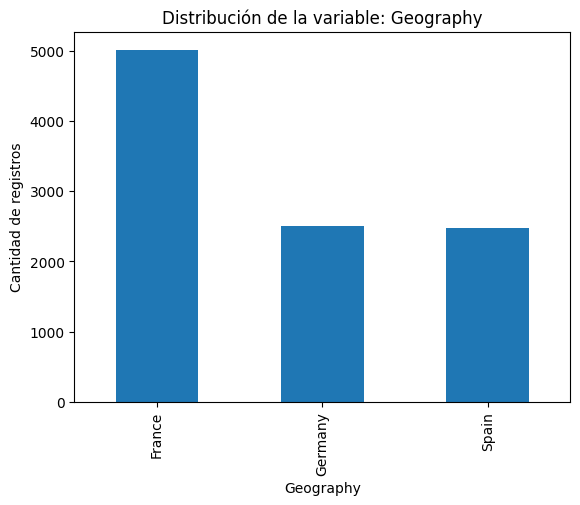

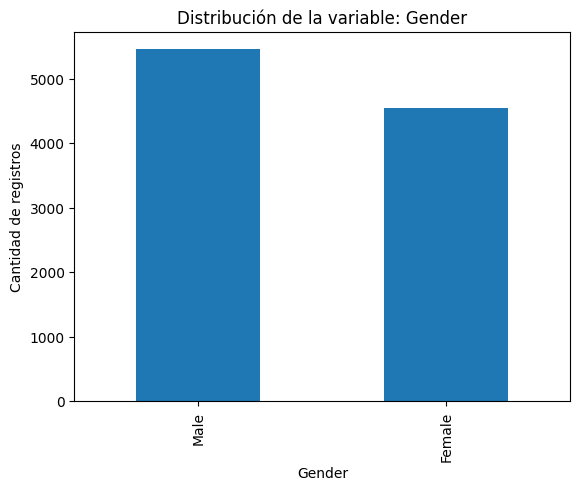

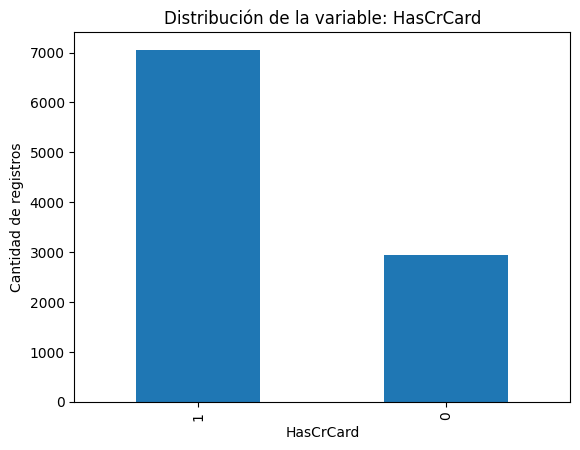

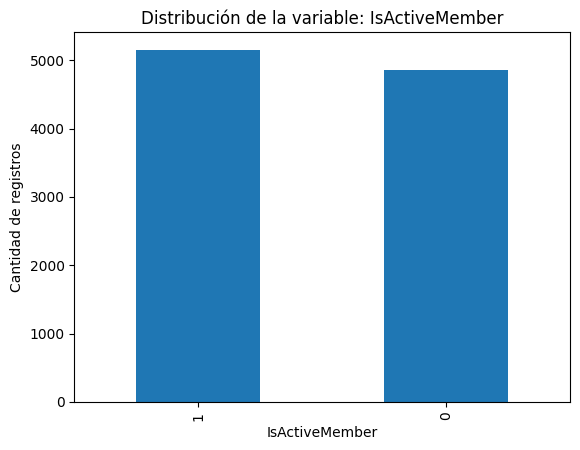

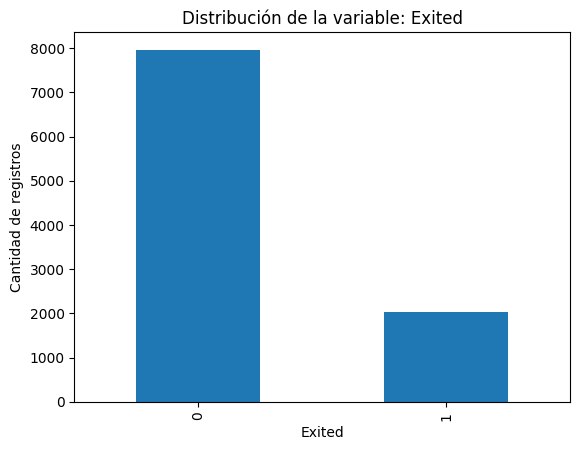

In [106]:
categoricas = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

for col in categoricas:
    df_bank[col].value_counts().plot(kind='bar')
    plt.title(f'Distribución de la variable: {col}')
    plt.xlabel(col)
    plt.ylabel('Cantidad de registros')
    plt.show()


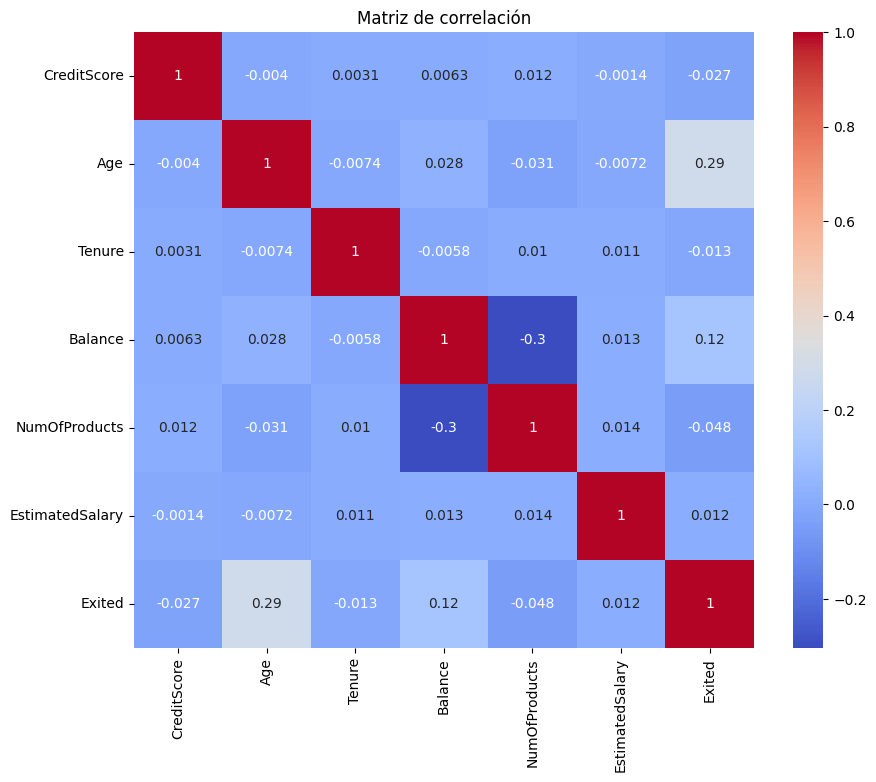

In [107]:
plt.figure(figsize=(10,8))
sns.heatmap(df_bank[numericas + ['Exited']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()


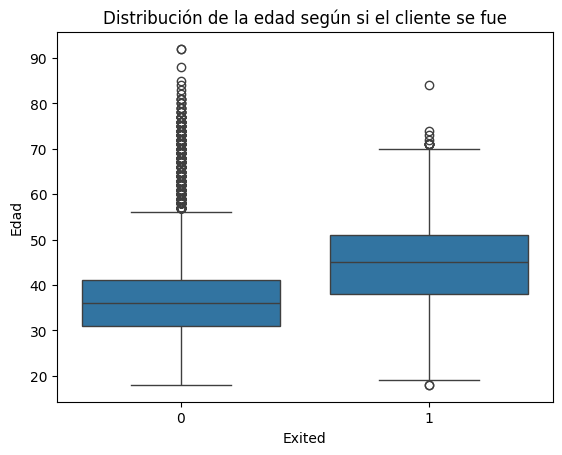

In [108]:
sns.boxplot(x='Exited', y='Age', data=df_bank)
plt.title('Distribución de la edad según si el cliente se fue')
plt.xlabel('Exited')
plt.ylabel('Edad')
plt.show()



##### Notas iniciales sobre lo observado

El análisis exploratorio muestra que el dataset contiene variables demográficas y bancarias sin valores nulos relevantes excepto en Tenure, donde los nulos indican clientes sin depósitos a plazo fijo y deben imputarse con 0. La variable objetivo (Exited) está desbalanceada, predominando los clientes que permanecen. Se observan diferencias de edad y productos entre quienes se quedan y se van, y no hay correlaciones numéricas extremas. El siguiente paso es preparar los datos y abordar el desbalance de clases para modelado.

### Comparación de Modelos Antes y Después del Balanceo

In [109]:
columnas_quitar = ['RowNumber', 'CustomerId', 'Surname']
df_bank_numerico = df_bank.drop(columns=columnas_quitar)

In [110]:
X_class = df_bank_numerico.drop(['Exited'], axis =1)
y_class = df_bank_numerico['Exited']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

In [112]:
X_train = pd.get_dummies(X_train, columns=['Geography', 'Gender'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Geography', 'Gender'], drop_first=True)


# Asegúrate de que ambos dataframes tengan las mismas columnas:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [113]:
print(X_train.dtypes)


CreditScore            int64
Age                    int64
Tenure               float64
Balance              float64
NumOfProducts          int64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Geography_Germany       bool
Geography_Spain         bool
Gender_Male             bool
dtype: object


In [114]:
modelo_class_randomforest = RandomForestClassifier(n_estimators=300, random_state=42)
modelo_class_randomforest.fit(X_train, y_train)
y_pred_RF = modelo_class_randomforest.predict(X_test)


# Evaluamos
accuracy = accuracy_score(y_test, y_pred_RF)
print(f"🔵 Precisión del modelo de Clasificación RandomForest: {accuracy:.2f}")

🔵 Precisión del modelo de Clasificación RandomForest: 0.87


In [115]:
modelo_class_DecisionTree = DecisionTreeClassifier(max_depth=10, random_state=42)  # Limitamos la profundidad a 3 para que sea más entendible
modelo_class_DecisionTree.fit(X_train, y_train)

# Evaluamos el modelo_class_DecisionTree
y_pred_DT = modelo_class_DecisionTree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_DT)
print(f"🌳 Precisión del modelo_class_DecisionTree: {accuracy:.2f}")

🌳 Precisión del modelo_class_DecisionTree: 0.84


In [116]:
print(f"🌳 Precisión del modelo_class_RandomForest:")
print(classification_report(y_test, y_pred_RF))
print(f"🌳 Precisión del modelo_class_DecisionTree:")
print(classification_report(y_test, y_pred_DT))

🌳 Precisión del modelo_class_RandomForest:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2416
           1       0.77      0.47      0.58       584

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000

🌳 Precisión del modelo_class_DecisionTree:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      2416
           1       0.61      0.47      0.53       584

    accuracy                           0.84      3000
   macro avg       0.74      0.70      0.72      3000
weighted avg       0.83      0.84      0.83      3000



Aqui podemos observar las metricas de nuestros 2 modelos de clasificación random fores y tree classifier con los datos SIN BALANCEAR. 

#### Modelo Balanceado


In [117]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

modelo_RF_bal = RandomForestClassifier(random_state=42)
modelo_RF_bal.fit(X_train_bal, y_train_bal)
y_pred_bal_RF = modelo_RF_bal.predict(X_test)

# Resultados después de balancear
print("\n📌 Reporte después de balancear con SMOTE en RandomFores:")
print(classification_report(y_test, y_pred_bal_RF))




modelo_class_DecisionTree = DecisionTreeClassifier(max_depth=10, random_state=42) 
modelo_class_DecisionTree.fit(X_train_bal, y_train_bal)
y_pred_bal_DT = modelo_class_DecisionTree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_bal_DT)
print("\n📌 Reporte después de balancear con SMOTE con Decision Tree:")
print(classification_report(y_test, y_pred_bal_DT))


📌 Reporte después de balancear con SMOTE en RandomFores:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2416
           1       0.58      0.62      0.60       584

    accuracy                           0.84      3000
   macro avg       0.74      0.76      0.75      3000
weighted avg       0.84      0.84      0.84      3000


📌 Reporte después de balancear con SMOTE con Decision Tree:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      2416
           1       0.48      0.66      0.56       584

    accuracy                           0.80      3000
   macro avg       0.70      0.74      0.71      3000
weighted avg       0.83      0.80      0.81      3000



In [118]:
y_pred_bal = modelo_RF_bal.predict(X_test)
y_prob = modelo_RF_bal.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [119]:
accuracy = accuracy_score(y_test, y_pred_bal)
precision = precision_score(y_test, y_pred_bal)
recall = recall_score(y_test, y_pred_bal)
f1 = f1_score(y_test, y_pred_bal)
roc_auc = roc_auc_score(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)



print(f"🔹 Accuracy: {accuracy:.2f}")
print(f"🔹 Precision: {precision:.2f}")
print(f"🔹 Recall: {recall:.2f}")
print(f"🔹 F1-Score: {f1:.2f}")
print(f"🔹 ROC-AUC: {roc_auc:.2f}")
print(f"🔹 Average Precision (AP): {average_precision:.2f}")

🔹 Accuracy: 0.84
🔹 Precision: 0.58
🔹 Recall: 0.62
🔹 F1-Score: 0.60
🔹 ROC-AUC: 0.84
🔹 Average Precision (AP): 0.62


#### Ahora balancearemos con Oversampling

In [120]:

# predicción en test
y_pred_bal_OS = modelo_RF_bal.predict(X_test)
y_prob = modelo_RF_bal.predict_proba(X_test)[:, 1] 

# las métricas siempre comparan y_test con las predicciones en test
accuracy = accuracy_score(y_test, y_pred_bal_OS)
precision = precision_score(y_test, y_pred_bal_OS)
recall = recall_score(y_test, y_pred_bal_OS)
f1 = f1_score(y_test, y_pred_bal_OS)
roc_auc = roc_auc_score(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

print("\n📌 Reporte después de balancear con RandomOverSampler en RandomForest:")
print(classification_report(y_test, y_pred_bal_OS))
print(f"🔹 Accuracy: {accuracy:.2f}")
print(f"🔹 Precision: {precision:.2f}")
print(f"🔹 Recall: {recall:.2f}")
print(f"🔹 F1-Score: {f1:.2f}")
print(f"🔹 ROC-AUC: {roc_auc:.2f}")
print(f"🔹 Average Precision (AP): {average_precision:.2f}")




📌 Reporte después de balancear con RandomOverSampler en RandomForest:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      2416
           1       0.58      0.62      0.60       584

    accuracy                           0.84      3000
   macro avg       0.74      0.76      0.75      3000
weighted avg       0.84      0.84      0.84      3000

🔹 Accuracy: 0.84
🔹 Precision: 0.58
🔹 Recall: 0.62
🔹 F1-Score: 0.60
🔹 ROC-AUC: 0.84
🔹 Average Precision (AP): 0.62


### Conclusiones:

La comparación muestra que antes del balanceo ambos modelos, Random Forest y Decision Tree, presentaban un recall bajo para la clase minoritaria (1: clientes que se van), especialmente en el Random Forest (recall = 0.47, F1 = 0.58) y Decision Tree (recall = 0.47, F1 = 0.53), a pesar de una alta precisión general. Esto refleja un sesgo hacia la clase mayoritaria y dificultad para identificar correctamente a los clientes en riesgo de abandono.

Después de aplicar técnicas de balanceo como RandomOverSampler y SMOTE, el recall y el F1-score de la clase minoritaria mejoraron notablemente en ambos casos (RandomOverSampler: recall = 0.54, F1 = 0.60; SMOTE: recall = 0.62, F1 = 0.60). Aunque la precisión general y el accuracy se mantuvieron similares, el modelo es ahora más capaz de detectar clientes que podrían dejar el banco, lo que es clave para la toma de decisiones y retención de clientes.

En resumen, el balanceo permitió un modelo más equilibrado y efectivo para la detección de la clase minoritaria, incrementando su utilidad para los objetivos del negocio bancario.